## Запуск

+ country - страна-производитель вина
+ description - подробное описание
+ designation - название виноградника, где выращивают виноград для вина
+ points - количество баллов, которое WineEnthusiast оценил вино по шкале от 1 до 100
+ price - стоимость бутылки вина
+ province - провинция или штат 
+ region_1 - винодельческий район в провинции или штате (например, Напа)
+ region_2 - конкретный регион. Иногда в пределах винодельческой зоны указываются более конкретные регионы (например, Резерфорд в долине Напа), но это значение иногда может быть пустым.
+ taster_name - имя дегустатора
+ taster_twitter_handle - твиттер дегустатора
+ title - название вина, который часто содержит годи др подробную информацию
+ variety -  сорт винограда, из которого изготовлено вино (например, Пино Нуар).
+ winery - винодельня, которая производила вино

In [4]:
import pandas as pd
import dtale


In [5]:
df = pd.read_csv('Data\wine_cleared.csv')  # чтение данных
print(f"Размер датасета: {df.shape}")
print("Первые 5 строк:")
df.head()

Размер датасета: (129971, 13)
Первые 5 строк:


,Unnamed: 0,country,description,designation,points,price,province,region_1,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,35.363389,Sicily & Sardinia,Etna,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.000000,Douro,unknown,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",unknown,87,14.000000,Oregon,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.000000,Michigan,Lake Michigan Shore,Alexander Peartree,unknown,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.000000,Oregon,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


## Создание признаков

### даты и времени

In [6]:
# для удобства сразу преобразуем признак в int 
df['price_round'] = df['price'].round().astype(int)

In [7]:
def extract_wine_year(title, designation):
    """
    Извлекает год производства вина из title, исключая годы из названия виноградника
    """
    import re
    regex = r'(1[8-9]\d{2}|20[0-2]\d)'
    
    # Находим все годы в title
    years_in_title = re.findall(regex, str(title))
    
    if not years_in_title:
        return None
    
    # Если designation не пустой, исключаем годы из него
    if pd.notna(designation) and designation != 'unknown':
        years_in_designation = re.findall(regex, str(designation))
        # Оставляем только те годы, которых нет в designation
        valid_years = [year for year in years_in_title if year not in years_in_designation]
        if valid_years:
            return valid_years[-1]  # берем последний валидный год
    
    # Если designation пустой или все годы валидные, берем последний год
    return years_in_title[-1]

df['year'] = df.apply(lambda row: extract_wine_year(row['title'], row['designation']), axis=1)
# regex = '\d{4}' # регулярное выражение для нахождения чисел
# df['year'] = df['title'].str.findall(regex).str.get(0)

In [8]:
dtale.show(df)


In [9]:

df['is_usa'] = df['country'].apply(lambda x: 1 if x == 'US' else 0)
df['is_italy'] = df['country'].apply(lambda x: 1 if x == 'Italy' else 0)
df['is_france'] = df['country'].apply(lambda x: 1 if x == 'France' else 0)

# преобразуем признак year в объект datetime для удобного сравнения дат
df['year'] = pd.to_datetime(df['year'], errors='coerce')

# для сравнения используем год, заполняем значения признака old_wine, где год вина меньше 2010
df['old_wine'] = df['year'].apply(lambda x: 1 if x.year < 2010 else 0) 
df['old_wine'].sum()


39677

In [10]:
# Анализ проблемных строк для проверки правильности выбора года
import re

def analyze_year_extraction(df):
    """
    Анализирует качество извлечения годов и показывает проблемные случаи
    """
    regex = r'(1[8-9]\d{2}|20[0-2]\d)'
    
    # Находим строки с множественными годами в title
    multiple_years = []
    designation_conflicts = []
    
    for idx, row in df.iterrows():
        title = str(row['title'])
        designation = str(row['designation'])
        extracted_year = row['year']
        
        # Находим все годы в title
        years_in_title = re.findall(regex, title)
        years_in_designation = re.findall(regex, designation) if designation != 'nan' and designation != 'unknown' else []
        
        # Случаи с множественными годами
        if len(years_in_title) > 1:
            multiple_years.append({
                'index': idx,
                'title': title,
                'designation': designation,
                'years_in_title': years_in_title,
                'years_in_designation': years_in_designation,
                'extracted_year': extracted_year
            })
        
        # Случаи с годами в designation
        if years_in_designation:
            designation_conflicts.append({
                'index': idx,
                'title': title,
                'designation': designation,
                'years_in_title': years_in_title,
                'years_in_designation': years_in_designation,
                'extracted_year': extracted_year
            })
    
    print("=== СТРОКИ С МНОЖЕСТВЕННЫМИ ГОДАМИ В TITLE ===")
    print(f"Найдено {len(multiple_years)} строк с несколькими годами")
    for i, case in enumerate(multiple_years[:10]):  # показываем первые 10
        print(f"\n{i+1}. Index: {case['index']}")
        print(f"   Title: {case['title']}")
        print(f"   Designation: {case['designation']}")
        print(f"   Годы в title: {case['years_in_title']}")
        print(f"   Годы в designation: {case['years_in_designation']}")
        print(f"   Извлеченный год: {case['extracted_year']}")
    
    print(f"\n=== СТРОКИ С ГОДАМИ В DESIGNATION ===")
    print(f"Найдено {len(designation_conflicts)} строк с годами в designation")
    for i, case in enumerate(designation_conflicts[:10]):  # показываем первые 10
        print(f"\n{i+1}. Index: {case['index']}")
        print(f"   Title: {case['title']}")
        print(f"   Designation: {case['designation']}")
        print(f"   Годы в title: {case['years_in_title']}")
        print(f"   Годы в designation: {case['years_in_designation']}")
        print(f"   Извлеченный год: {case['extracted_year']}")
    
    return multiple_years, designation_conflicts

# Запускаем анализ
multiple_years_cases, designation_conflicts_cases = analyze_year_extraction(df)


=== СТРОКИ С МНОЖЕСТВЕННЫМИ ГОДАМИ В TITLE ===
Найдено 304 строк с несколькими годами

1. Index: 1012
   Title: Antichi Vinai 1877 2013 Pietralava Red (Etna)
   Designation: Pietralava
   Годы в title: ['1877', '2013']
   Годы в designation: []
   Извлеченный год: 2013-01-01 00:00:00

2. Index: 1512
   Title: Pascal Aufranc 2011 Vignes de 1939  (Chénas)
   Designation: Vignes de 1939
   Годы в title: ['2011', '1939']
   Годы в designation: ['1939']
   Извлеченный год: 2011-01-01 00:00:00

3. Index: 2634
   Title: Caccia al Piano 1868 2009 Ruit Hora  (Bolgheri)
   Designation: Ruit Hora
   Годы в title: ['1868', '2009']
   Годы в designation: []
   Извлеченный год: 2009-01-01 00:00:00

4. Index: 2660
   Title: Donna Olimpia 1898 2009 Tageto Red (Toscana)
   Designation: Tageto
   Годы в title: ['1898', '2009']
   Годы в designation: []
   Извлеченный год: 2009-01-01 00:00:00

5. Index: 2858
   Title: San Pedro 2014 1865 Single Vineyard Cabernet Sauvignon (Maipo Valley)
   Designation: 1

In [11]:
# Дополнительный анализ: проверка качества извлечения года
def check_extraction_quality(df, sample_size=20):
    """
    Показывает случайную выборку для ручной проверки качества извлечения года
    """
    regex = r'(1[8-9]\d{2}|20[0-2]\d)'
    
    # Берем случайную выборку строк с годами
    sample_df = df[df['year'].notna()].sample(n=min(sample_size, len(df)), random_state=42)
    
    print("=== СЛУЧАЙНАЯ ВЫБОРКА ДЛЯ ПРОВЕРКИ КАЧЕСТВА ===")
    for idx, row in sample_df.iterrows():
        title = str(row['title'])
        designation = str(row['designation'])
        extracted_year = row['year']
        
        years_in_title = re.findall(regex, title)
        years_in_designation = re.findall(regex, designation) if designation != 'nan' and designation != 'unknown' else []
        
        print(f"\nIndex: {idx}")
        print(f"Title: {title}")
        print(f"Designation: {designation}")
        print(f"Все годы в title: {years_in_title}")
        print(f"Годы в designation: {years_in_designation}")
        print(f"Извлеченный год: {extracted_year}")
        print("-" * 80)

# Статистика по извлечению годов
def year_extraction_stats(df):
    """
    Показывает статистику извлечения годов
    """
    total_rows = len(df)
    rows_with_year = df['year'].notna().sum()
    rows_without_year = total_rows - rows_with_year
    
    print("=== СТАТИСТИКА ИЗВЛЕЧЕНИЯ ГОДОВ ===")
    print(f"Всего строк: {total_rows}")
    print(f"Строк с извлеченным годом: {rows_with_year} ({rows_with_year/total_rows*100:.1f}%)")
    print(f"Строк без года: {rows_without_year} ({rows_without_year/total_rows*100:.1f}%)")
    
    if rows_with_year > 0:
        year_counts = df['year'].value_counts().head(10)
        print(f"\nТоп-10 самых частых годов:")
        for year, count in year_counts.items():
            print(f"  {year}: {count} раз")
        
        # Проверяем диапазон годов
        years_numeric = pd.to_numeric(df['year'], errors='coerce')
        min_year = years_numeric.min()
        max_year = years_numeric.max()
        print(f"\nДиапазон годов: {int(min_year)} - {int(max_year)}")

# Запускаем дополнительный анализ
print("\\n" + "="*50)
year_extraction_stats(df)
print("\\n" + "="*50)
check_extraction_quality(df, sample_size=15)


\n==================================================
=== СТАТИСТИКА ИЗВЛЕЧЕНИЯ ГОДОВ ===
Всего строк: 129971
Строк с извлеченным годом: 125360 (96.5%)
Строк без года: 4611 (3.5%)

Топ-10 самых частых годов:
  2013-01-01 00:00:00: 15875 раз
  2012-01-01 00:00:00: 15747 раз
  2014-01-01 00:00:00: 15582 раз
  2011-01-01 00:00:00: 12558 раз
  2010-01-01 00:00:00: 12167 раз
  2015-01-01 00:00:00: 10052 раз
  2009-01-01 00:00:00: 9878 раз
  2008-01-01 00:00:00: 7439 раз
  2007-01-01 00:00:00: 7053 раз
  2006-01-01 00:00:00: 5772 раз

Диапазон годов: -9223372036854775808 - 1483228800000000000
\n==================================================
=== СЛУЧАЙНАЯ ВЫБОРКА ДЛЯ ПРОВЕРКИ КАЧЕСТВА ===

Index: 90682
Title: Quivira 2014 Black Boar Zinfandel (Dry Creek Valley)
Designation: Black Boar
Все годы в title: ['2014']
Годы в designation: []
Извлеченный год: 2014-01-01 00:00:00
--------------------------------------------------------------------------------

Index: 31335
Title: Robert Hall 2014 Me

In [12]:
# Создание признака locality (название долины/местности производства)
def extract_locality(title):
    """
    Извлекает название долины/местности из title вина
    Ищет текст в круглых скобках в конце названия
    """
    if pd.isna(title) or title == 'unknown':
        return None
    
    # Паттерн для поиска текста в скобках в конце строки
    pattern = r'\(([^)]+)\)\s*$'
    match = re.search(pattern, title)
    
    if match:
        locality = match.group(1).strip()
        # Исключаем годы (4 цифры подряд)
        if not re.match(r'^\d{4}$', locality):
            return locality
    
    return None

# Применяем функцию для создания нового признака
df['locality'] = df['title'].apply(extract_locality)

# Статистика по признаку locality
print("=== СТАТИСТИКА ПО ПРИЗНАКУ LOCALITY ===")
total_rows = len(df)
rows_with_locality = df['locality'].notna().sum()
rows_without_locality = total_rows - rows_with_locality

print(f"Всего строк: {total_rows}")
print(f"Строк с locality: {rows_with_locality} ({rows_with_locality/total_rows*100:.1f}%)")
print(f"Строк без locality: {rows_without_locality} ({rows_without_locality/total_rows*100:.1f}%)")

if rows_with_locality > 0:
    print(f"\nТоп-15 самых частых locality:")
    locality_counts = df['locality'].value_counts().head(15)
    for locality, count in locality_counts.items():
        print(f"  {locality}: {count} раз")

# Примеры извлечения locality
print("\n=== ПРИМЕРЫ ИЗВЛЕЧЕНИЯ LOCALITY ===")
sample_indices = df[df['locality'].notna()].sample(n=min(10, rows_with_locality)).index

for idx in sample_indices:
    title = df.loc[idx, 'title']
    locality = df.loc[idx, 'locality']
    print(f"Title: {title}")
    print(f"Locality: {locality}")
    print("-" * 60)

print(f"\nКоличество уникальных locality: {df['locality'].nunique()}")


=== СТАТИСТИКА ПО ПРИЗНАКУ LOCALITY ===
Всего строк: 129971
Строк с locality: 113763 (87.5%)
Строк без locality: 16208 (12.5%)

Топ-15 самых частых locality:
  Napa Valley: 4480 раз
  Russian River Valley: 3091 раз
  California: 2629 раз
  Paso Robles: 2350 раз
  Mendoza: 2301 раз
  Alsace: 2163 раз
  Willamette Valley: 1999 раз
  Champagne: 1611 раз
  Finger Lakes: 1564 раз
  Sonoma Coast: 1474 раз
  Rioja: 1394 раз
  Barolo: 1330 раз
  Douro: 1281 раз
  Sonoma County: 1246 раз
  Toscana: 1197 раз

=== ПРИМЕРЫ ИЗВЛЕЧЕНИЯ LOCALITY ===
Title: Clayhouse 2007 Cabernet Sauvignon (Paso Robles)
Locality: Paso Robles
------------------------------------------------------------
Title: Husch 2012 Estate Bottled Pinot Noir (Anderson Valley)
Locality: Anderson Valley
------------------------------------------------------------
Title: Lamoreaux Landing 2014 T23 Unoaked Cabernet Franc (Finger Lakes)
Locality: Finger Lakes
------------------------------------------------------------
Title: Falesco 2

### Внешние источники данных

In [13]:
country_population = pd.read_csv('Data/country_population.csv', sep=';')

country_population

,country,population
0,China,"1,411,778,724"
1,India,"1,386,584,581"
2,US,"333,022,386"
3,Indonesia,"271,350,000"
4,Pakistan,"225,200,000"
...,...,...
236,Niue,"1,549"
237,Tokelau,"1,501"
238,Vatican City,825
239,Cocos Islands,573


In [14]:
df.join(country_population.set_index('country'), on='country')

,Unnamed: 0,country,description,designation,points,price,province,region_1,taster_name,taster_twitter_handle,...,variety,winery,price_round,year,is_usa,is_italy,is_france,old_wine,locality,population
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,35.363389,Sicily & Sardinia,Etna,Kerin O’Keefe,@kerinokeefe,...,White Blend,Nicosia,35,2013-01-01,0,1,0,0,Etna,"59,097,904"
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.000000,Douro,unknown,Roger Voss,@vossroger,...,Portuguese Red,Quinta dos Avidagos,15,2011-01-01,0,0,0,0,Douro,"10,347,892"
2,2,US,"Tart and snappy, the flavors of lime flesh and...",unknown,87,14.000000,Oregon,Willamette Valley,Paul Gregutt,@paulgwine,...,Pinot Gris,Rainstorm,14,2013-01-01,1,0,0,0,Willamette Valley,"333,022,386"
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.000000,Michigan,Lake Michigan Shore,Alexander Peartree,unknown,...,Riesling,St. Julian,13,2013-01-01,1,0,0,0,Lake Michigan Shore,"333,022,386"
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.000000,Oregon,Willamette Valley,Paul Gregutt,@paulgwine,...,Pinot Noir,Sweet Cheeks,65,2012-01-01,1,0,0,0,Willamette Valley,"333,022,386"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129966,129966,Germany,Notes of honeysuckle and cantaloupe sweeten th...,Brauneberger Juffer-Sonnenuhr Spätlese,90,28.000000,Mosel,unknown,Anna Lee C. Iijima,unknown,...,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef),28,2013-01-01,0,0,0,0,Mosel,"83,129,285"
129967,129967,US,Citation is given as much as a decade of bottl...,unknown,90,75.000000,Oregon,Oregon,Paul Gregutt,@paulgwine,...,Pinot Noir,Citation,75,2004-01-01,1,0,0,1,Oregon,"333,022,386"
129968,129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.000000,Alsace,Alsace,Roger Voss,@vossroger,...,Gewürztraminer,Domaine Gresser,30,2013-01-01,0,0,1,0,Alsace,"68,035,000"
129969,129969,France,"A dry style of Pinot Gris, this is crisp with ...",unknown,90,32.000000,Alsace,Alsace,Roger Voss,@vossroger,...,Pinot Gris,Domaine Marcel Deiss,32,2012-01-01,0,0,1,0,Alsace,"68,035,000"


In [15]:
country_area = pd.read_csv('Data/country_area.csv', sep=';')
country_area

,country,area
0,Russia,17075400.00
1,Canada,9984670.00
2,China,9596960.00
3,US,9372610.00
4,Brazil,8547000.00
...,...,...
188,San Marino,61.00
189,Tuvalu,26.00
190,Nauru,21.00
191,Monaco,2.00


In [16]:
# Добавляем признак area_country (площадь страны)
df = df.join(country_area.set_index('country'), on='country')
df = df.rename(columns={'area': 'area_country'})

# Находим площадь страны для указанного вина
wine_title = 'Gård 2014 Grand Klasse Reserve Lawrence Vineyards Viognier (Columbia Valley (WA))'
wine_area = df[df['title'] == wine_title]['area_country'].iloc[0]
print(f"Площадь страны для вина '{wine_title}': {wine_area}")
print(f"Площадь округленная до целых: {round(wine_area)}")


Площадь страны для вина 'Gård 2014 Grand Klasse Reserve Lawrence Vineyards Viognier (Columbia Valley (WA))': 9372610.0
Площадь округленная до целых: 9372610


In [17]:
# Создание бинарных признаков для стран
df['is_usa'] = df['country'].apply(lambda x: 1 if x == 'US' else 0)
df['is_italy'] = df['country'].apply(lambda x: 1 if x == 'Italy' else 0)
df['is_france'] = df['country'].apply(lambda x: 1 if x == 'France' else 0)



### Работа с форматом «дата-время»

In [18]:
df['year'] = pd.to_datetime(df['year'], errors = 'coerce')
# Создаем признак количество дней с момента произведения вина
reference_date = pd.to_datetime('2022-01-12')
df['years_diff'] = (reference_date - df['year']).dt.days

# Находим максимальное количество дней
max_days = df['years_diff'].max()
print(f"Максимальное количество дней с момента произведения вина: {round(max_days)}")


Максимальное количество дней с момента произведения вина: 73425


## Кодирование признаков. Методы

In [19]:
import category_encoders as ce

Рассмотрим следующие популярные способы кодирования: 

порядковое кодирование (Ordinal Encoding); 
однократное кодирование (OneHot Encoding); 
бинарное кодирование (Binary Encoding).

### порядковое кодирование

In [20]:
import category_encoders as ce

ord_encoder = ce.OrdinalEncoder()
year_col = ord_encoder.fit_transform(df['year'])
data = pd.concat([df, year_col], axis=1)


In [21]:
# Финальная проверка всех созданных признаков
print("=== ФИНАЛЬНАЯ ПРОВЕРКА DATAFRAME ===")
print(f"Размер DataFrame: {df.shape}")
print(f"\nВсе столбцы:")
for i, col in enumerate(df.columns):
    print(f"{i+1:2d}. {col}")

print(f"\nПроверяем наличие ключевых признаков:")
key_features = ['is_usa', 'is_italy', 'is_france', 'old_wine', 'locality', 'area_country']
for feature in key_features:
    if feature in df.columns:
        print(f"✅ {feature}: НАЙДЕН")
        if df[feature].dtype in ['int64', 'float64']:
            print(f"   Сумма: {df[feature].sum()}")
        else:
            print(f"   Уникальных значений: {df[feature].nunique()}")
    else:
        print(f"❌ {feature}: НЕ НАЙДЕН")

# Показываем образец данных с новыми признаками
print(f"\nОбразец итоговых данных:")
sample_cols = ['country', 'is_usa', 'is_italy', 'is_france', 'year', 'old_wine']
available_cols = [col for col in sample_cols if col in df.columns]
print(df[available_cols].head(10))


=== ФИНАЛЬНАЯ ПРОВЕРКА DATAFRAME ===
Размер DataFrame: (129971, 22)

Все столбцы:
 1. Unnamed: 0
 2. country
 3. description
 4. designation
 5. points
 6. price
 7. province
 8. region_1
 9. taster_name
10. taster_twitter_handle
11. title
12. variety
13. winery
14. price_round
15. year
16. is_usa
17. is_italy
18. is_france
19. old_wine
20. locality
21. area_country
22. years_diff

Проверяем наличие ключевых признаков:
✅ is_usa: НАЙДЕН
   Сумма: 54504
✅ is_italy: НАЙДЕН
   Сумма: 19540
✅ is_france: НАЙДЕН
   Сумма: 22093
✅ old_wine: НАЙДЕН
   Сумма: 39677
✅ locality: НАЙДЕН
   Уникальных значений: 1534
✅ area_country: НАЙДЕН
   Сумма: 571089459401.0

Образец итоговых данных:
    country  is_usa  is_italy  is_france       year  old_wine
0     Italy       0         1          0 2013-01-01         0
1  Portugal       0         0          0 2011-01-01         0
2        US       1         0          0 2013-01-01         0
3        US       1         0          0 2013-01-01         0
4     

### однократное кодирование

In [22]:
# OneHot кодирование признака taster_name (имя сомелье)
print("=== КОДИРОВАНИЕ ПРИЗНАКА TASTER_NAME ===")

# Анализ признака taster_name перед кодированием
print(f"Размер DataFrame до кодирования: {df.shape}")
print(f"Уникальные значения taster_name: {df['taster_name'].nunique()}")
print(f"Пропущенные значения: {df['taster_name'].isna().sum()}")

# Показываем топ-10 самых активных сомелье
print(f"\nТоп-10 самых активных сомелье:")
top_tasters = df['taster_name'].value_counts().head(10)
for taster, count in top_tasters.items():
    print(f"  {taster}: {count} обзоров")


=== КОДИРОВАНИЕ ПРИЗНАКА TASTER_NAME ===
Размер DataFrame до кодирования: (129971, 22)
Уникальные значения taster_name: 20
Пропущенные значения: 0

Топ-10 самых активных сомелье:
  unknown: 26244 обзоров
  Roger Voss: 25514 обзоров
  Michael Schachner: 15134 обзоров
  Kerin O’Keefe: 10776 обзоров
  Virginie Boone: 9537 обзоров
  Paul Gregutt: 9532 обзоров
  Matt Kettmann: 6332 обзоров
  Joe Czerwinski: 5147 обзоров
  Sean P. Sullivan: 4966 обзоров
  Anna Lee C. Iijima: 4415 обзоров


In [23]:
# Применяем OneHot кодирование к признаку taster_name
print("=== ПРИМЕНЕНИЕ ONEHOT КОДИРОВАНИЯ ===")

# Создаем OneHot кодировщик для taster_name
onehot_encoder = ce.OneHotEncoder(cols=['taster_name'], use_cat_names=True)

# Применяем кодирование
taster_encoded = onehot_encoder.fit_transform(df[['taster_name']])

# Добавляем закодированные признаки к исходному DataFrame
df_with_taster_encoding = pd.concat([df, taster_encoded], axis=1)

print(f"Размер DataFrame после кодирования: {df_with_taster_encoding.shape}")
print(f"Исходный размер: {df.shape}")
print(f"Добавлено столбцов: {df_with_taster_encoding.shape[1] - df.shape[1]}")


=== ПРИМЕНЕНИЕ ONEHOT КОДИРОВАНИЯ ===
Размер DataFrame после кодирования: (129971, 42)
Исходный размер: (129971, 22)
Добавлено столбцов: 20


In [24]:
# Отображение данных в браузере через dtale
d = dtale.show(df_with_taster_encoding)
print(f"Откройте в браузере: {d._url}")

Откройте в браузере: http://Rigel:40000


### Двоичное кодирование

In [25]:
# Двоичное кодирование признака country
print("=== АНАЛИЗ ПРИЗНАКА COUNTRY ПЕРЕД КОДИРОВАНИЕМ ===")
print(f"Уникальные значения country: {df['country'].nunique()}")
print(f"Пропущенные значения: {df['country'].isna().sum()}")

print(f"\nТоп-10 стран по количеству вин:")
country_counts = df['country'].value_counts().head(10)
for country, count in country_counts.items():
    print(f"  {country}: {count} вин")



=== АНАЛИЗ ПРИЗНАКА COUNTRY ПЕРЕД КОДИРОВАНИЕМ ===
Уникальные значения country: 43
Пропущенные значения: 63

Топ-10 стран по количеству вин:
  US: 54504 вин
  France: 22093 вин
  Italy: 19540 вин
  Spain: 6645 вин
  Portugal: 5691 вин
  Chile: 4472 вин
  Argentina: 3800 вин
  Austria: 3345 вин
  Australia: 2329 вин
  Germany: 2165 вин


In [26]:
# Применяем Binary кодирование к признаку country
print("=== ПРИМЕНЕНИЕ BINARY КОДИРОВАНИЯ К COUNTRY ===")

# Создаем Binary кодировщик для country
binary_encoder = ce.BinaryEncoder(cols=['country'])

# Применяем кодирование
country_binary_encoded = binary_encoder.fit_transform(df[['country']])

print(f"Размер исходного DataFrame: {df.shape}")
print(f"Размер закодированных данных: {country_binary_encoded.shape}")

# Показываем названия новых столбцов
binary_columns = [col for col in country_binary_encoded.columns if col.startswith('country_')]
print(f"\nСоздано новых признаков: {len(binary_columns)}")
print(f"Названия новых признаков: {binary_columns}")

# Добавляем закодированные признаки к исходному DataFrame
df_with_country_binary = pd.concat([df, country_binary_encoded], axis=1)

print(f"\nРазмер DataFrame после добавления Binary кодирования: {df_with_country_binary.shape}")
print(f"Добавлено столбцов: {df_with_country_binary.shape[1] - df.shape[1]}")


=== ПРИМЕНЕНИЕ BINARY КОДИРОВАНИЯ К COUNTRY ===
Размер исходного DataFrame: (129971, 22)
Размер закодированных данных: (129971, 6)

Создано новых признаков: 6
Названия новых признаков: ['country_0', 'country_1', 'country_2', 'country_3', 'country_4', 'country_5']

Размер DataFrame после добавления Binary кодирования: (129971, 28)
Добавлено столбцов: 6


In [27]:
# Анализ результатов Binary кодирования
print("=== АНАЛИЗ РЕЗУЛЬТАТОВ BINARY КОДИРОВАНИЯ ===")

# Показываем примеры кодирования для разных стран
sample_countries = ['US', 'Italy', 'France', 'Spain', 'Portugal', 'Germany']
print("Примеры Binary кодирования для разных стран:")
print("-" * 60)

for country in sample_countries:
    if country in df['country'].values:
        # Находим индекс первого вхождения страны
        idx = df[df['country'] == country].index[0]
        country_row = df_with_country_binary.loc[idx]
        
        print(f"Страна: {country}")
        binary_values = []
        for col in binary_columns:
            binary_values.append(str(country_row[col]))
        print(f"Binary код: [{', '.join(binary_values)}]")
        print("-" * 30)

print(f"\nЭффективность Binary кодирования:")
unique_countries_count = df['country'].nunique()
print(f"Количество уникальных стран: {unique_countries_count}")
print(f"Binary кодирование создало: {len(binary_columns)} признаков")

# Сравнение с OneHot кодированием
print(f"OneHot кодирование создало бы: {unique_countries_count} признаков")
efficiency = unique_countries_count / len(binary_columns)
print(f"Экономия места: в {efficiency:.1f} раза меньше столбцов!")

# Формула для расчета количества битов
import math
required_bits = math.ceil(math.log2(unique_countries_count))
print(f"\nТеоретически требуется битов: ⌈log₂({unique_countries_count})⌉ = {required_bits}")
print(f"Фактически создано: {len(binary_columns)} признаков")


=== АНАЛИЗ РЕЗУЛЬТАТОВ BINARY КОДИРОВАНИЯ ===
Примеры Binary кодирования для разных стран:
------------------------------------------------------------
Страна: US
Binary код: [0, 0, 0, 0, 1, 1]
------------------------------
Страна: Italy
Binary код: [0, 0, 0, 0, 0, 1]
------------------------------
Страна: France
Binary код: [0, 0, 0, 1, 0, 1]
------------------------------
Страна: Spain
Binary код: [0, 0, 0, 1, 0, 0]
------------------------------
Страна: Portugal
Binary код: [0, 0, 0, 0, 1, 0]
------------------------------
Страна: Germany
Binary код: [0, 0, 0, 1, 1, 0]
------------------------------

Эффективность Binary кодирования:
Количество уникальных стран: 43
Binary кодирование создало: 6 признаков
OneHot кодирование создало бы: 43 признаков
Экономия места: в 7.2 раза меньше столбцов!

Теоретически требуется битов: ⌈log₂(43)⌉ = 6
Фактически создано: 6 признаков


In [28]:
# Проверка корректности Binary кодирования
print("=== ПРОВЕРКА КОРРЕКТНОСТИ КОДИРОВАНИЯ ===")

# Проверяем, что каждая строка имеет уникальную комбинацию Binary кодов для каждой страны
print("Проверка уникальности кодирования по странам:")

# Группируем по стране и проверяем, что все строки одной страны имеют одинаковый Binary код
for country in df['country'].unique()[:5]:  # Проверяем первые 5 стран
    country_data = df_with_country_binary[df_with_country_binary['country'] == country]
    
    # Получаем Binary коды для этой страны
    binary_subset = country_data[binary_columns]
    binary_codes = binary_subset.drop_duplicates()
    
    print(f"Страна '{country}': {len(binary_codes)} уникальных Binary кода(ов)")
    if len(binary_codes) == 1:
        code_values = [str(binary_codes.iloc[0][col]) for col in binary_columns]
        print(f"  Binary код: [{', '.join(code_values)}]")
    else:
        print(f"  ⚠️ ОШИБКА: Найдено несколько кодов для одной страны!")

print(f"\n=== ИТОГОВЫЙ РЕЗУЛЬТАТ ===")
print(f"🎯 ОТВЕТ НА ВОПРОС:")
print(f"После двоичного кодирования признака 'country' образовалось {len(binary_columns)} новых признаков")
print(f"Названия новых признаков: {binary_columns}")

# Сохраняем результат в переменную для дальнейшего использования
df_final = df_with_country_binary
print(f"\nФинальный размер DataFrame: {df_final.shape}")
print(f"Добавлено признаков: {len(binary_columns)}")


=== ПРОВЕРКА КОРРЕКТНОСТИ КОДИРОВАНИЯ ===
Проверка уникальности кодирования по странам:
Страна 'Italy': 1 уникальных Binary кода(ов)
  Binary код: [0, 0, 0, 0, 0, 1]
Страна 'Portugal': 1 уникальных Binary кода(ов)
  Binary код: [0, 0, 0, 0, 1, 0]
Страна 'US': 1 уникальных Binary кода(ов)
  Binary код: [0, 0, 0, 0, 1, 1]
Страна 'Spain': 1 уникальных Binary кода(ов)
  Binary код: [0, 0, 0, 1, 0, 0]
Страна 'France': 1 уникальных Binary кода(ов)
  Binary код: [0, 0, 0, 1, 0, 1]

=== ИТОГОВЫЙ РЕЗУЛЬТАТ ===
🎯 ОТВЕТ НА ВОПРОС:
После двоичного кодирования признака 'country' образовалось 6 новых признаков
Названия новых признаков: ['country_0', 'country_1', 'country_2', 'country_3', 'country_4', 'country_5']

Финальный размер DataFrame: (129971, 28)
Добавлено признаков: 6


### Практика

In [29]:
import pandas as pd
import category_encoders as ce

df = pd.read_csv('Data/wine_cleared.csv')

print(f'Уникальных значений taster_twitter_handle: {df["taster_twitter_handle"].nunique()}')

# OneHot кодирование
encoder = ce.BinaryEncoder(cols=['taster_twitter_handle'])
encoded = encoder.fit_transform(df[['taster_twitter_handle']])
new_cols = [col for col in encoded.columns if col.startswith('taster_twitter_handle_')]

print(f'Ответ: {len(new_cols)} признаков')

Уникальных значений taster_twitter_handle: 16
Ответ: 5 признаков


In [30]:
import pandas as pd
import category_encoders as ce

list_of_dicts = [
 {'product': 'Product1', 'price': 1200, 'payment_type': 'Mastercard'},
 {'product': 'Product2', 'price': 3600, 'payment_type': 'Visa'},
 {'product': 'Product3', 'price': 7500, 'payment_type': 'Amex'}
]   
df = pd.DataFrame(list_of_dicts)

# 1. OneHot кодирование для product
print("\n1. Кодирование признака 'product':")
product_encoder = ce.OneHotEncoder(cols=['product'], use_cat_names=True)
product_encoded = product_encoder.fit_transform(df[['product']])
print("Результат OneHot кодирования для product:")
print(product_encoded)

# 2. Признак price остается без изменений
print("\n2. Признак 'price' не требует кодирования (уже числовой)")

# 3. OneHot кодирование для payment_type
print("\n3. Кодирование признака 'payment_type':")
payment_encoder = ce.OneHotEncoder(cols=['payment_type'], use_cat_names=True)
payment_encoded = payment_encoder.fit_transform(df[['payment_type']])
print("Результат OneHot кодирования для payment_type:")
print(payment_encoded)

# Объединяем все закодированные признаки
print(f"\n=== ФИНАЛЬНЫЙ РЕЗУЛЬТАТ ===")
df_final = pd.concat([
    df[['price']],  # числовой признак без изменений
    product_encoded,  # закодированный product
    payment_encoded   # закодированный payment_type
], axis=1)

print("Итоговый датасет после кодирования:")
print(df_final)

print(f"\nСтатистика:")
print(f"- Исходное количество столбцов: {df.shape[1]}")
print(f"- Итоговое количество столбцов: {df_final.shape[1]}")
print(f"- Добавлено столбцов: {df_final.shape[1] - df.shape[1]}")


1. Кодирование признака 'product':
Результат OneHot кодирования для product:
   product_Product1  product_Product2  product_Product3
0                 1                 0                 0
1                 0                 1                 0
2                 0                 0                 1

2. Признак 'price' не требует кодирования (уже числовой)

3. Кодирование признака 'payment_type':
Результат OneHot кодирования для payment_type:
   payment_type_Mastercard  payment_type_Visa  payment_type_Amex
0                        1                  0                  0
1                        0                  1                  0
2                        0                  0                  1

=== ФИНАЛЬНЫЙ РЕЗУЛЬТАТ ===
Итоговый датасет после кодирования:
   price  product_Product1  product_Product2  product_Product3  \
0   1200                 1                 0                 0   
1   3600                 0                 1                 0   
2   7500                 0   

## Преобразование признаков. Нормализация. Стандартизация

In [31]:
from sklearn.preprocessing import RobustScaler

# Применяем RobustScaler к признаку 'price'
scaler = RobustScaler()
df_final['price_normalized'] = scaler.fit_transform(df_final[['price']])

print("Нормализованный признак 'price':")
print(df_final[['price', 'price_normalized']])

# Для ответа на вопрос: вычислим сумму price в исходном датафрейме (df)
print("\nСумма значений 'price' (округлено):")
print(round(df['price'].sum()))



Нормализованный признак 'price':
   price  price_normalized
0   1200         -0.761905
1   3600          0.000000
2   7500          1.238095

Сумма значений 'price' (округлено):
12300


In [32]:
from sklearn.preprocessing import StandardScaler

# Стандартизация признака 'price' в исходном датафрейме df
scaler_std = StandardScaler()
df['price_standardized'] = scaler_std.fit_transform(df[['price']])

print("Стандартизированный признак 'price' (первые 5 значений):")
print(df[['price', 'price_standardized']].head())

data['price'][129968]

Стандартизированный признак 'price' (первые 5 значений):
   price  price_standardized
0   1200           -1.117038
1   3600           -0.192593
2   7500            1.309631


30.0

## Корреляция признаков

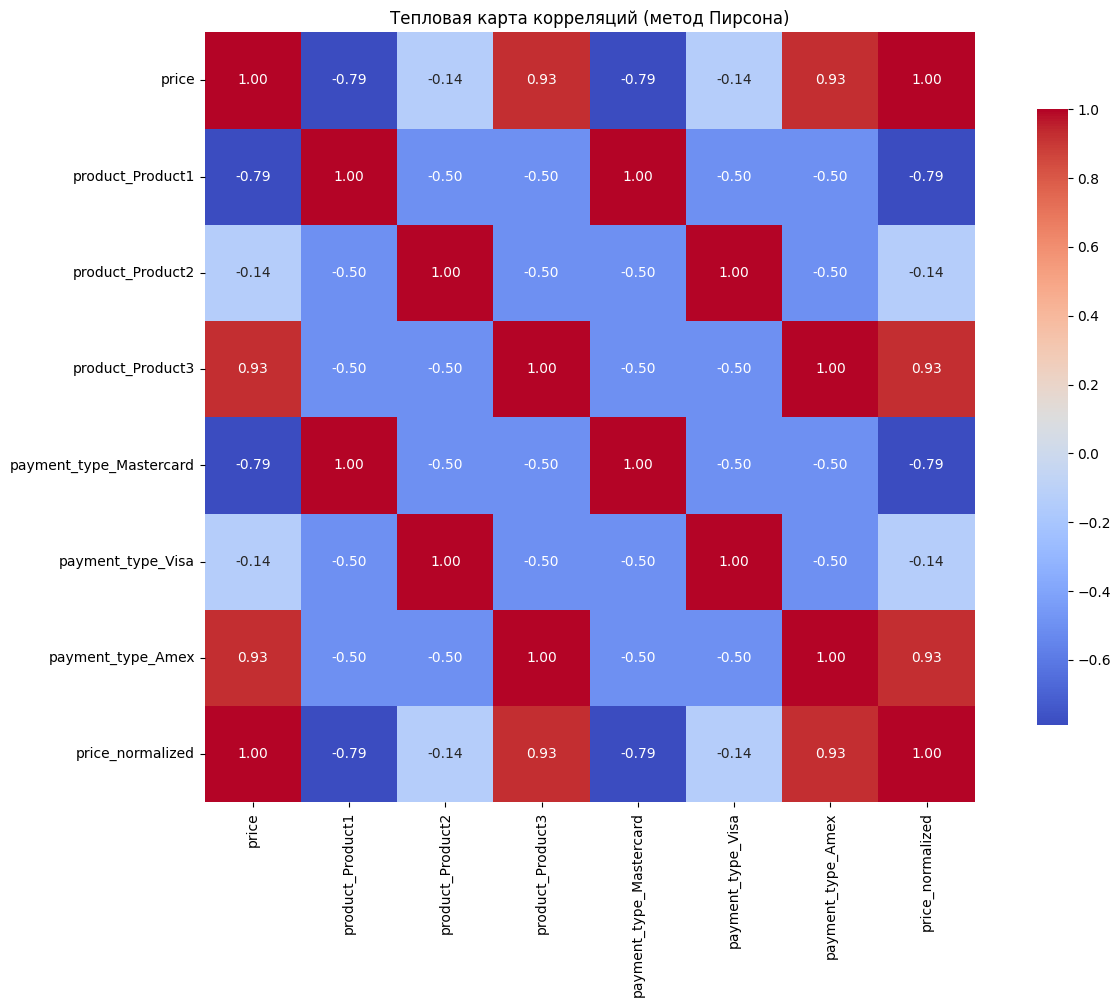

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Вычисляем корреляционную матрицу только для числовых признаков, используя корреляцию Пирсона
corr_matrix = df_final.corr(method='pearson')

plt.figure(figsize=(16, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Тепловая карта корреляций (метод Пирсона)')
plt.show()
